In [1]:
## This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
from mlrefined_libraries import math_optimization_library as optlib
from mlrefined_libraries import nonlinear_superlearn_library as nonlib
from mlrefined_libraries import recurrent_library as recurlib

# demos for this notebook
regress_plotter = nonlib.nonlinear_regression_demos
static_plotter = optlib.static_plotter.Visualizer()
basic_runner = nonlib.basic_runner
datapath = '../../mlrefined_datasets/recurrent_datasets/'

# import autograd functionality to bulid function's properly for optimizers
import autograd.numpy as np

# import timer
from datetime import datetime 
import copy
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
from autograd.misc.flatten import flatten_func

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

import autograd.numpy as np
from autograd import grad

%load_ext autoreload
%autoreload 2

# grad test

In [16]:
def h(x,y):
    return x**2*y
h_x = grad(h,0) # derivative with respect to x
h_y = grad(h,1) # derivative with respect to t

In [17]:
x = np.linspace(0,1,100)
y = 4.0

In [18]:
blah = np.array([h_y(v,y) for v in x])

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

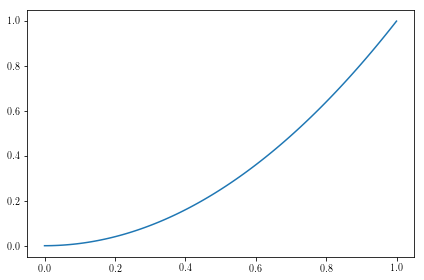

In [20]:
plt.plot(x,blah)
plt.show()

# try with least squares

In [54]:
# compute linear combination of input point
def model(x,w):        
    a = np.dot(x.T,w)
    return a.T

# an implementation of the least squares cost function for linear regression
def least_squares(w,x,y):    
    cost = np.sum((model(x,w) - y)**2)
    return cost/float(np.size(y))

# imports
from autograd import value_and_grad

# load in data

In [95]:
# load in data
datapath = '../../mlrefined_datasets/superlearn_datasets/'
data = np.loadtxt(datapath + '2d_linregress_data.csv',delimiter = ',')

# load in input/output data
x = data[:-1,:]
y = data[-1:,:] 

# stack a 1 onto the top of each input point all at once
o = np.ones((1,np.shape(x)[1]))
x = np.vstack((o,x))

In [96]:
gradient = grad(least_squares,0)

In [97]:
w = 0.1*np.random.randn(x.shape[0],1)
grad_eval = gradient(w,x,y)

In [98]:
grad_eval

array([[-1.33494019],
       [-0.75804499]])

In [99]:
grad_eval.shape

(2, 1)

In [118]:
g_flat, unflatten, w = flatten_func(least_squares, w)
gradient = grad(g_flat,1)
grad_eval = gradient(w,x,y)

In [119]:
grad_eval

array([[ 0.0049544 ,  0.00224242,  0.00134187,  0.00091782,  0.00376347,
         0.00214039,  0.00396518,  0.00234734,  0.00193499,  0.00291687,
         0.00282956,  0.00369674,  0.00135858,  0.00648854,  0.00030313,
         0.0051545 ,  0.0036697 ,  0.00293436,  0.00466464,  0.00248924,
         0.00479583,  0.00411204,  0.0040933 ,  0.0042716 ,  0.00604954,
         0.00271158,  0.00474241,  0.00564299,  0.00109406,  0.00106587,
         0.00517086,  0.00508453,  0.00404933,  0.00571015,  0.00199768,
         0.0028044 ,  0.00252757,  0.00497822,  0.00486531,  0.00132617,
         0.00093718,  0.0035151 ,  0.00101396,  0.00117707,  0.0066251 ,
         0.00337019,  0.00583096,  0.0015069 ,  0.00419994,  0.00608835],
       [ 0.00935242,  0.004233  ,  0.00253305,  0.00173256,  0.0071043 ,
         0.00404041,  0.00748506,  0.00443108,  0.00365268,  0.00550617,
         0.00534135,  0.00697834,  0.0025646 ,  0.01224841,  0.00057222,
         0.00973014,  0.00692729,  0.00553918,  0.

In [115]:
grad_eval.shape

(2,)

In [116]:
from inspect import signature
signature(least_squares)

<Signature (w, x, y)>

In [117]:
signature(g_flat)

<Signature (_x, *args)>

In [112]:
g_flat(w,x,y)

array([ 0.55624937])

# gradient descent 

In [36]:
# using an automatic differentiator - like the one imported via the statement below - makes coding up gradient descent a breeze
from autograd import value_and_grad 

# gradient descent function - inputs: g (input function), alpha (steplength parameter), max_its (maximum number of iterations), w (initialization)
def gradient_descent(g,w,x,y,alpha,max_its):
    gradient = value_and_grad(g,0)

    # run the gradient descent loop
    weight_history = []      # container for weight history
    cost_history = []        # container for corresponding cost function history
    for k in range(1,max_its+1):
        # evaluate the gradient, store current weights and cost function value
        cost_eval,grad_eval = gradient(w,x,y)
        weight_history.append(w)
        cost_history.append(cost_eval)

        # take gradient descent step
        w = w - alpha*grad_eval
            
    # collect final weights
    weight_history.append(w)
    cost_history.append(g(w,x,y))  
    return weight_history,cost_history

In [37]:
g = least_squares
w = 0.1*np.random.randn(x.shape[0],1)
alpha = 10**(-1)
max_its = 10
weight_history,cost_history = gradient_descent(g,w,x,y,alpha,max_its)

# minibatch and flat testing

In [47]:
from autograd import value_and_grad 
from autograd.misc.flatten import flatten_func
from timeit import default_timer as timer

# compute linear combination of input point
def model(x,w):        
    a = np.dot(x.T,w)
    return a.T

# an implementation of the least squares cost function for linear regression
def least_squares(w,x,y,iter):
    # get batch of points
    x_p = x[:,iter]
    y_p = y[:,iter]

    # compute cost over batch
    cost = np.sum((model(x_p,w) - y_p)**2)
    return cost/float(np.size(y_p))

In [53]:
w = 0.1*np.random.randn(x.shape[0],1)
g_flat, unflatten, w = flatten_func(least_squares, w)
gradient = grad(least_squares,0)
cost_eval,grad_eval = gradient(w,x,y)

In [48]:
# minibatch gradient descent
def gradient_descent(g,w,x_train,y_train,x_val,y_val,alpha,max_its,batch_size): 
    verbose = True
    
    # flatten the input function, create gradient based on flat function
    g_flat, unflatten, w = flatten_func(g, w)
    grad = value_and_grad(g_flat)

    # record history
    num_train = y_train.size
    num_val = y_val.size
    w_hist = [unflatten(w)]
    train_hist = [g_flat(w,x_train,y_train,np.arange(num_train))]
    val_hist = [g_flat(w,x_val,y_val,np.arange(num_val))]

    # how many mini-batches equal the entire dataset?
    num_batches = int(np.ceil(np.divide(num_train, batch_size)))

    # over the line
    for k in range(max_its):                   
        # loop over each minibatch
        start = timer()
        train_cost = 0
        for b in range(num_batches):
            # collect indices of current mini-batch
            batch_inds = np.arange(b*batch_size, min((b+1)*batch_size, num_train))
            
            # plug in value into func and derivative
            cost_eval,grad_eval = grad(w,x,y,batch_inds)
            grad_eval.shape = np.shape(w)
    
            # take descent step with momentum
            w = w - alpha*grad_eval
        print (w.shape)
        end = timer()
        
        # update training and validation cost
        train_cost = g_flat(w,x_train,y_train,np.arange(num_train))
        val_cost = g_flat(w,x_val,y_val,np.arange(num_val))

        # record weight update, train and val costs
        w_hist.append(unflatten(w))
        train_hist.append(train_cost)
        val_hist.append(val_cost)

        if verbose == True:
            print ('step ' + str(k+1) + ' done in ' + str(np.round(end - start,1)) + ' secs, train cost = ' + str(np.round(train_hist[-1][0],4)) + ', val cost = ' + str(np.round(val_hist[-1][0],4)))

    if verbose == True:
        print ('finished all ' + str(max_its) + ' steps')
        #time.sleep(1.5)
        #clear_output()
    return w_hist,train_hist,val_hist

In [49]:
# create training and validation datasets
r = np.random.permutation(y.size)

In [50]:
x_train = x[:,r[:40]]
y_train = y[:,r[:40]]

x_val = x[:,r[40:]]
y_val = y[:,r[40:]]

In [51]:
g = least_squares
w = 0.1*np.random.randn(x.shape[0],1)
alpha = 10**(-1)
max_its = 2
batch_size = 10
weight_hist,train_hist,val_hist = gradient_descent(g,w,x_train,y_train,x_val,y_val,alpha,max_its,batch_size)

(2,)
step 1 done in 0.0 secs, train cost = 0.0726, val cost = 0.0796
(2,)
step 2 done in 0.0 secs, train cost = 0.0449, val cost = 0.0636
finished all 2 steps


In [52]:
w = 0.1*np.random.randn(x.shape[0],1)
g_flat, unflatten, w = flatten_func(least_squares, w)

In [143]:
least_squares(w,x,y,np.arange(y.size))

0.2825092845727461

In [144]:
g_flat(w,x,y,np.arange(y.size))

array([ 0.28250928])

# load in and window data

In [2]:
csvname = datapath + 'ford_data.csv'
data = pd.read_csv(csvname)
data = np.array(data['Close'])[np.newaxis,:]    # date: 1980 to 2017

In [3]:
def window_series(x,order):
    # containers for input/output pairs
    x_in = []
    x_out = []
    T = x.size
    
    # window data
    for t in range(T - order):
        # get input sequence
        temp_in = x[:,t:t + order]
        x_in.append(temp_in)
        
        # get corresponding target
        temp_out = x[:,t + order]
        x_out.append(temp_out)
        
    # make array and cut out redundant dimensions
    x_in = np.array(x_in)
    x_in = x_in.swapaxes(0,1)[0,:,:].T
    x_out = np.array(x_out).T
    return x_in,x_out

In [4]:
x,y = window_series(data,order = 5)

# new library development

<IPython.core.display.Javascript object>


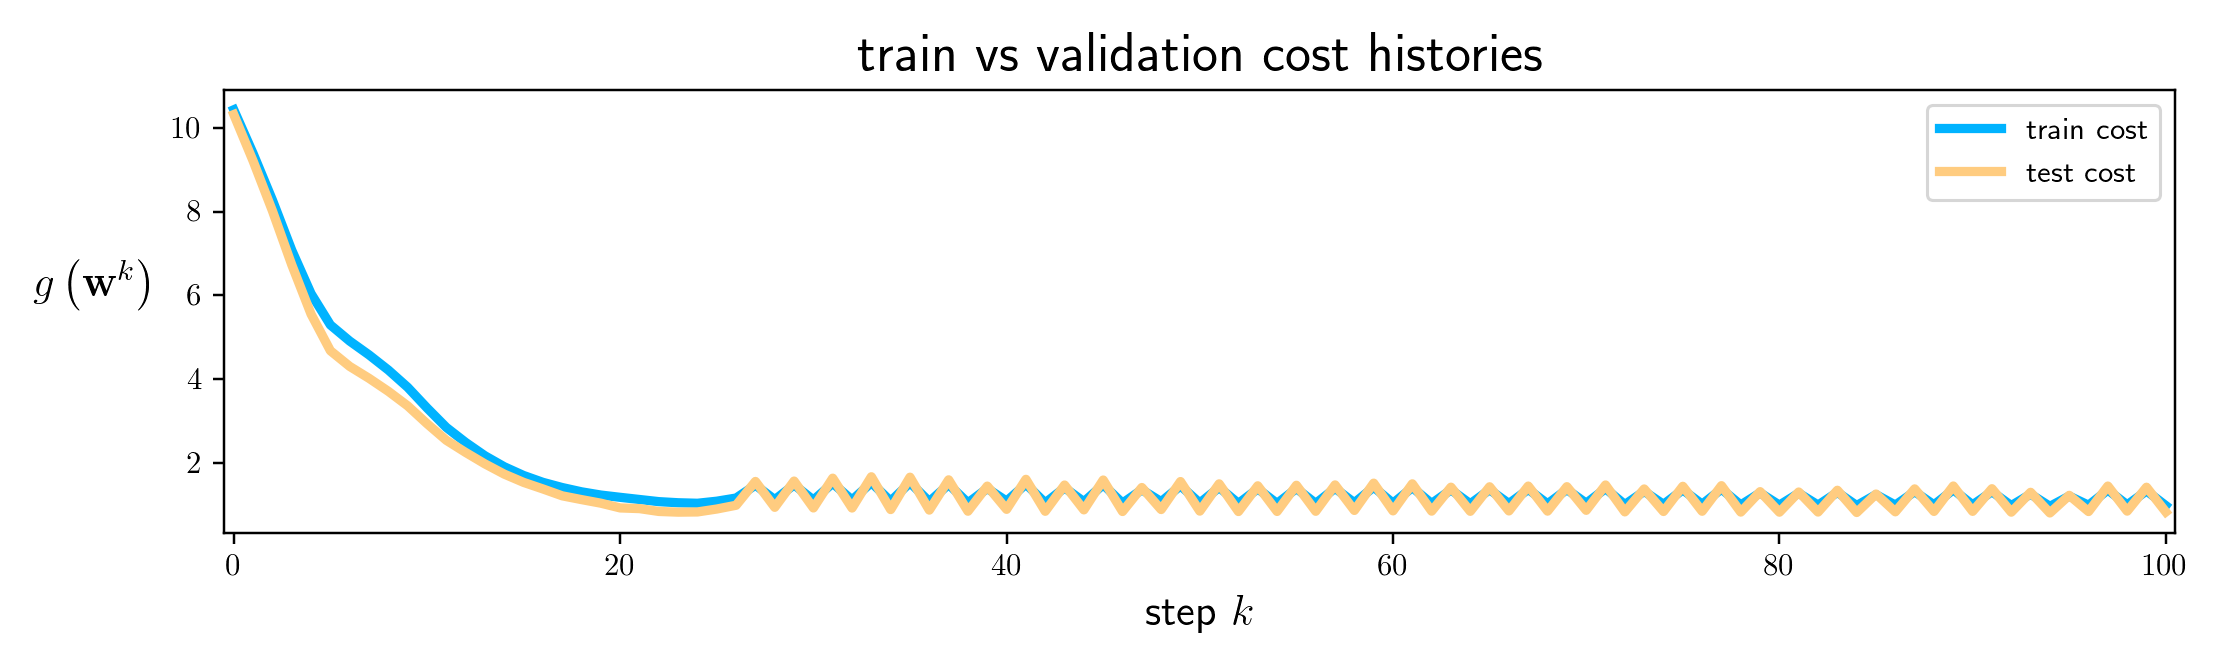

In [11]:
## This code cell will not be shown in the HTML version of this notebook
# import library runner
rnn_basics_lib = recurlib.RNN_basics_lib_v2

# initialize with input/output data
mylib1 = rnn_basics_lib.superlearn_setup.Setup(x,y)

# perform preprocessing step(s) - especially input normalization
mylib1.preprocessing_steps(normalizer = 'standard')

# split into training and validation sets
mylib1.make_train_val_split(train_portion = 0.8)

# choose cost
mylib1.choose_cost(name = 'least_absolute_deviations')

# choose dimensions of fully connected multilayer perceptron layers
layer_sizes = [10]
mylib1.choose_features(feature_name = 'multilayer_perceptron',layer_sizes = layer_sizes,activation = 'maxout',scale = 0.5)

# fit an optimizationx
mylib1.fit(max_its = 100,alpha_choice = 10**(-1),batch_size = mylib1.y.size,verbose = False)

# plot cost history
mylib1.show_histories(start = 0,labels = ['run 1'])

In [2]:
# load in data
datapath = '../../mlrefined_datasets/superlearn_datasets/'
data = np.loadtxt(datapath + '5class_wavy_multiclass.csv',delimiter = ',')

# tack on a one for bias
x = data[:-1,:]
y = data[-1:,:] - 1

In [16]:
y

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,
         2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,
         3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  4.,  4.,
         4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
         4.,  4.,  4.]])

<IPython.core.display.Javascript object>


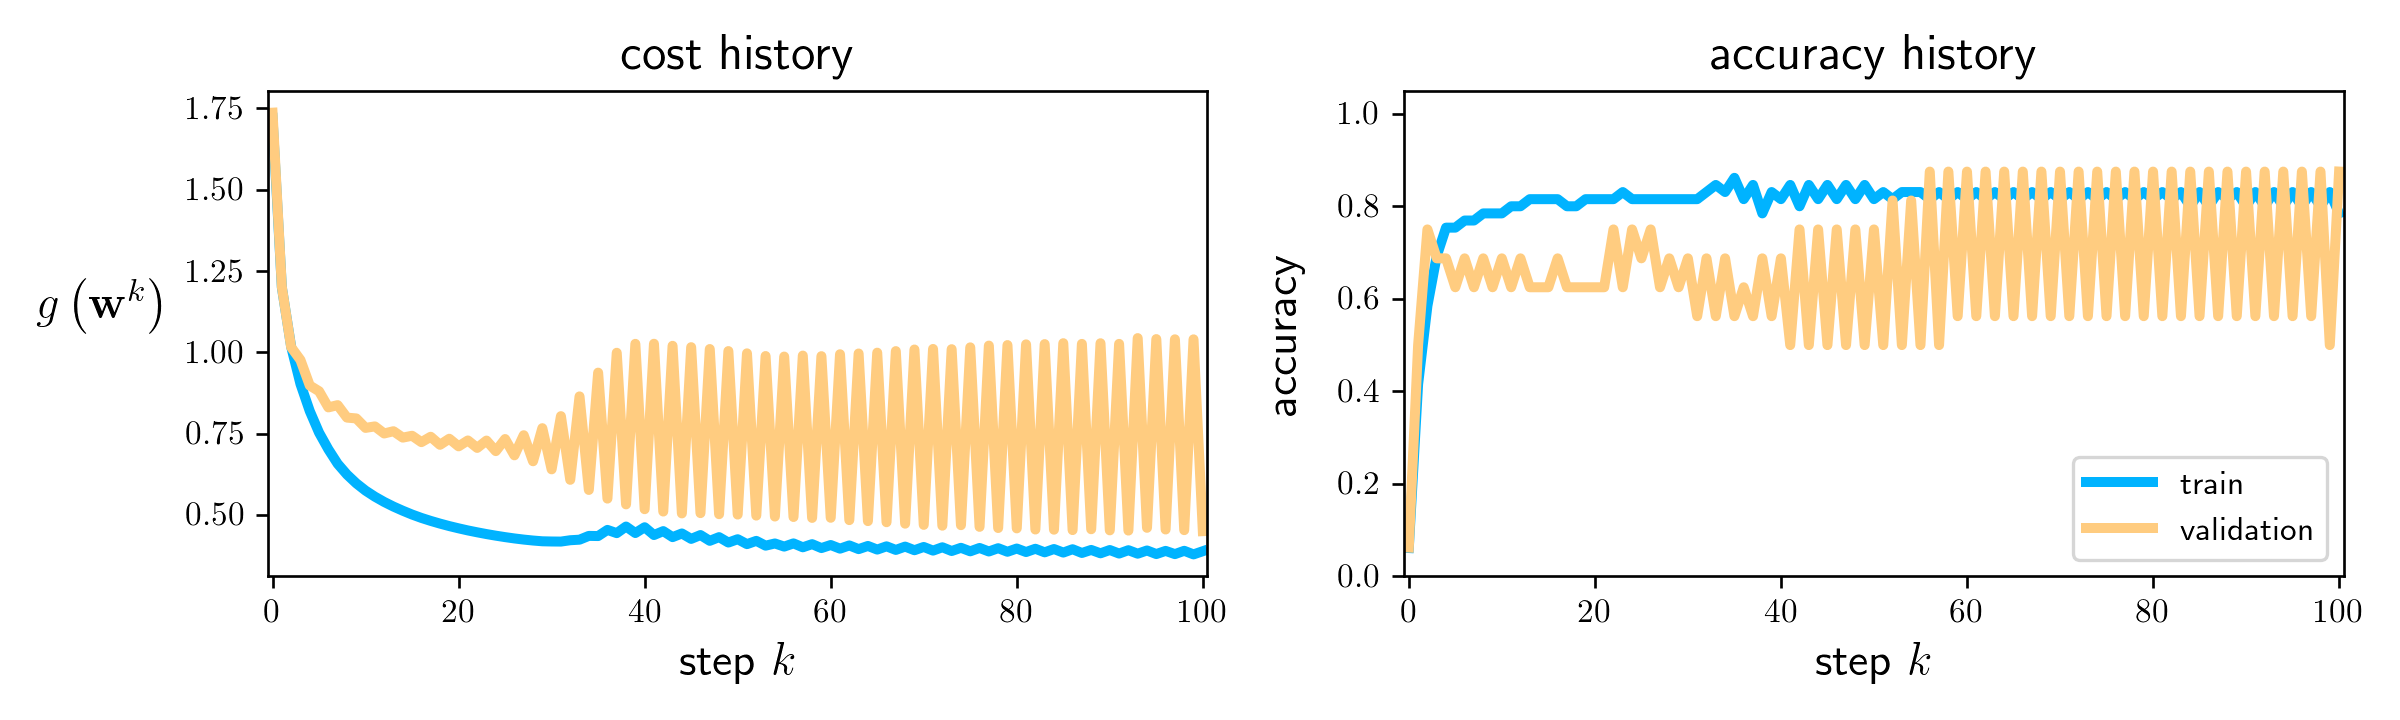

In [15]:
## This code cell will not be shown in the HTML version of this notebook
# import library runner
rnn_basics_lib = recurlib.RNN_basics_lib_v2

# initialize with input/output data
mylib1 = rnn_basics_lib.superlearn_setup.Setup(x,y)

# perform preprocessing step(s) - especially input normalization
mylib1.preprocessing_steps(normalizer = 'standard')

# split into training and validation sets
mylib1.make_train_val_split(train_portion = 0.8)

# choose cost
mylib1.choose_cost(name = 'multiclass_softmax')

# choose dimensions of fully connected multilayer perceptron layers
layer_sizes = [10]
mylib1.choose_features(feature_name = 'multilayer_perceptron_batch_normalized',layer_sizes = layer_sizes,activation = 'maxout',scale = 0.5)

# fit an optimizationx
mylib1.fit(max_its = 100,alpha_choice = 10**(0),batch_size = mylib1.y_train.size,verbose = False)

# plot cost history
mylib1.show_histories(start = 0)

In [99]:
mylib1.layer_sizes

[2, 10, 5]

In [100]:
mylib1.x.shape

(3, 81)

In [101]:
x.shape

(2, 81)

In [102]:
y.shape

(1, 81)

In [90]:
x.shape

(1, 53)